<h1><center> Individual Data Noise Creation <br><br> 
<center> Scikit Mobility and DB Noise<br><br> 
Wendy Shi</center></center>

# TOC

- [County Level FIP](#County-Level-FIP-Code)
- [Individual Data](#Individual-Data)
- [Census Tract Shape File](#Census-Tract-Shape-File)
- [Grouping](#Groupping)
    - [DP Noise](#DP-Noise)
    - [Home Location](#Home-Location)
    - [Testing](#Testing)
- [Computing Weight Matrix](#Computing-Weight-Matrix)

# Preparation

In [1]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

# County Level FIP Code

In [2]:
column_names = ['S', 'E', 'I', 'R']
Seeding = pd.read_csv("../../Data/seed_1503_seed_corrected_undereporting_CDC_corrected_v3.txt",
                     delimiter=' ',
                      names=column_names)
print(Seeding.shape)
Seeding.tail(3)

(2327, 4)


,S,E,I,R
2324,42158,0,0,0
2325,23347,0,0,0
2326,20441,0,0,0


In [3]:
node_dict = pd.read_csv("../../Data/nodes_considered.csv")
node_dict = node_dict.drop(columns = ['index'])
print(node_dict.shape)
node_dict.tail(3)

(2327, 1)


,GEO_ID
2324,56037
2325,56039
2326,56041


In [4]:
node_dict['Population'] = Seeding['S']
node_dict.tail(5)

,GEO_ID,Population
2322,56029,29656
2323,56033,30996
2324,56037,42158
2325,56039,23347
2326,56041,20441


In [5]:
#Check if node dictionary size equals to size of E, and see if they all have population larger than 11,000
desired = node_dict[node_dict['Population'] > 11000]
print(desired.shape)

node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}")

#rename column
rename = {'GEO_ID' : 'GEOID'}
node_dict = node_dict.rename(columns = rename)
node_dict.head(3)

(2327, 2)


,GEOID,Population
0,01001,58877
1,01003,233140
2,01005,25180


In [6]:
node_dict['state'] = node_dict['GEOID'].str[:2]
node_dict['index'] = range(len(node_dict))
node_dict.head(3)

,GEOID,Population,state,index
0,01001,58877,01,0
1,01003,233140,01,1
2,01005,25180,01,2


In [7]:
washington = node_dict[node_dict['state'] == '53']

#Index list--------------This is the one that check if weight matrix is in the same order as SEIR initial condition
E_wa_index = washington['GEOID'].to_list()

#Population list
pop_list = washington['Population'].tolist()

#Print the dataset
print(washington.shape)
washington.head(3)

(34, 4)


,GEOID,Population,state,index
2169,53001,20605,53,2169
2170,53003,22290,53,2170
2171,53005,207230,53,2171


In [9]:
index = washington['index'].tolist()
print(index)

[2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202]


# Original Matrix for reference

In [10]:
#Open the 12 weight matrix
column_names = ['origin', 'destination', 'count', 'weight']
for i in range(12):
    n = i +1
    
    df = pd.read_csv(f"../../Data/monthly_matrix_sd_county_month{n}_county.txt", 
                     delimiter=' ', names=column_names)
    
    #Making sure all origin and destination are states in New York
    df = df[(df['origin'].isin(index)) & (df['destination'].isin(index))]
    
    # Store the modified DataFrame
    globals()[f'wt_mt{n}'] = df

In [11]:
wt_mt12.head(3)

,origin,destination,count,weight
294885,2171,2192,12,0.000099
294886,2172,2192,12,0.000162
294887,2173,2192,12,0.000305


In [12]:
#Turn each data into a matrix
#Transform the dataframe to a matrix with pivot table
for i in range(12):
    n = i+1
    matrix = globals()[f'wt_mt{n}'].pivot_table(index='origin', 
                                                columns='destination', 
                                                values= 'weight', fill_value=0)
    matrix = matrix.reset_index()
    matrix = matrix.drop(columns = ["origin"]) #drop the origin column
    globals()[f'matrix{n}'] = matrix

In [13]:
for i in range(12):
    n = i +1
    count_df = globals()[f'matrix{n}'].multiply(pop_list, axis=0)
    globals()[f'count_df{n}'] = count_df

In [14]:
average_count_df = sum(globals()[f'count_df{i}'] for i in range(1, 13)) / 12
print(average_count_df.shape)
average_count_df.head(3)

(34, 34)


destination,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,...,2193,2194,2195,2196,2197,2198,2199,2200,2201,2202
0,12151.662419,17.627475,560.340654,60.654594,17.656413,21.548185,15.218646,31.194161,703.380402,1654.021273,...,25.171195,6.377557,42.925998,455.431359,25.062816,21.203416,39.459117,21.632337,66.573817,120.407465
1,15.849193,13617.828426,36.697340,19.521904,6.576210,19.827180,19.487958,12.308093,17.700209,17.453577,...,14.479513,4.677748,18.464733,265.113125,18.214178,13.905920,43.984781,11.547004,200.611572,25.286822
2,338.332425,61.447587,163263.282770,313.662910,60.132907,184.365669,64.323444,101.537866,13333.632625,604.552678,...,43.801239,33.412807,260.938597,1250.863380,119.376388,117.306599,1310.114847,67.245125,197.527139,3586.040501


In [15]:
#Turn count to weight
divisor = [average_count_df.iloc[i].sum() for i in range(34)]
average_wt_mt = average_count_df.div(divisor, axis=0)
average_wt_mt.head(3)

destination,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,...,2193,2194,2195,2196,2197,2198,2199,2200,2201,2202
0,0.727032,0.001055,0.033525,0.003629,0.001056,0.001289,0.000911,0.001866,0.042083,0.098960,...,0.001506,0.000382,0.002568,0.027248,0.001500,0.001269,0.002361,0.001294,0.003983,0.007204
1,0.001078,0.926653,0.002497,0.001328,0.000447,0.001349,0.001326,0.000838,0.001204,0.001188,...,0.000985,0.000318,0.001256,0.018040,0.001239,0.000946,0.002993,0.000786,0.013651,0.001721
2,0.001796,0.000326,0.866574,0.001665,0.000319,0.000979,0.000341,0.000539,0.070773,0.003209,...,0.000232,0.000177,0.001385,0.006639,0.000634,0.000623,0.006954,0.000357,0.001048,0.019034


In [16]:
average_wt_mt_np = average_wt_mt.to_numpy()

In [17]:
average_wt_mt_np[0][0]

0.7270324311196286

In [18]:
Pii_ori = [average_wt_mt_np[i][i] for i in range(34)]

In [19]:
data = Pii_ori 
mean_value = sum(data) / len(data)  # Mean
median_value = statistics.median(data)  # Median
min_value = min(data)  # Min
max_value = max(data)  # Max

# Output
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Length of the list: {len(Pii_ori)}")

Mean: 0.837928920653961
Median: 0.8471554353227371
Min: 0.6782801804868762
Max: 0.9592912167085899
Length of the list: 34


# Individual Data

## Different Layers of Census Data

- State (2 digit)
- County (5 digit)
- Census Tracts (4 digits)
- Census Block Groups
- Census tracts

In [20]:
data = pd.read_csv("WA_4Week_10000_realpop.csv")
data = data.drop(columns = 'Unnamed: 0')
print(data.shape)
data.head()

(4687481, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,47.499024,-122.224862
1,1,2020-03-01 12:41:14.411882,47.500657,-122.220274
2,1,2020-03-01 14:11:23.605911,47.531125,-122.357910
3,1,2020-03-01 14:33:43.544832,47.500657,-122.220274
4,1,2020-03-01 14:53:52.198258,47.531125,-122.357910


In [21]:
indi_visit_list = []
for i in range(10000):
    id_num = i+1
    #if i % 4000 == 0:
    #    print(i)
    indi_sub = data[data['uid'] == id_num]
    length = len(indi_sub)
    indi_visit_list.append(length)

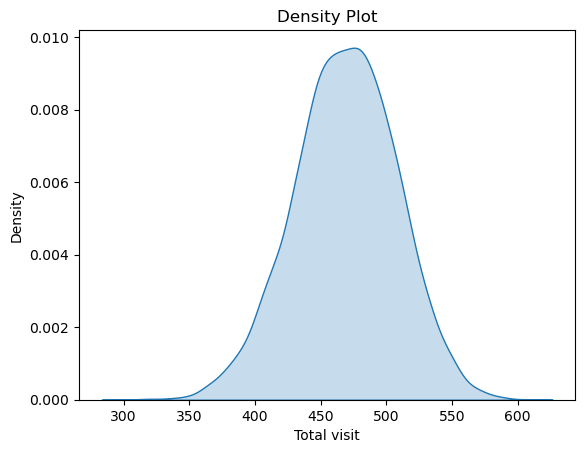

Min: 302
5%: 403.0
Median: 469.0
95%: 532.0
Max: 608


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(indi_visit_list, fill=True)
plt.xlabel('Total visit')
plt.ylabel('Density')
plt.title('Density Plot')
plt.show()

min_val = np.min(indi_visit_list)
P5 = np.percentile(indi_visit_list, 5)
median = np.median(indi_visit_list)
P95 = np.percentile(indi_visit_list, 95)
max_val = np.max(indi_visit_list)

print(f"Min: {min_val}")
print(f"5%: {P5}")
print(f"Median: {median}")
print(f"95%: {P95}")
print(f"Max: {max_val}")

# Census Tract Shape File

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
- Go to Data
- Mapping file
- TIGER/Line Geodatabases (GIS)


Here's the county level shape file:
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [23]:
#Note that geopandas only works in ipykernel environment
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads

## trying census block group this time!

In [24]:
#url = "https://www2.census.gov/geo/tiger/TIGER2020/BG/tl_2020_53_bg.zip"
#tracts = gpd.read_file(url)[["GEOID", "geometry"]]
tracts = gpd.read_file("tl_2020_53_bg/tl_2020_53_bg.shp")[["GEOID", "geometry"]]
print(tracts.columns)
print(tracts.shape)
tracts.head(1) 

Index(['GEOID', 'geometry'], dtype='object')
(5311, 2)


,GEOID,geometry
0,530039603004,"POLYGON ((-117.05053 46.41287, -117.05044 46.4..."


In [25]:
#Maing sure the shape file that we use to perform Geospacial join are all in countis of interest
tracts['County'] = tracts['GEOID'].str[:5].copy()
tracts = tracts[tracts['County'].isin(E_wa_index)]
print(tracts.shape)
tracts.head(3)

(5279, 3)


,GEOID,geometry,County
0,530039603004,"POLYGON ((-117.05053 46.41287, -117.05044 46.4...",53003
1,530039604001,"POLYGON ((-117.07434 46.41774, -117.07429 46.4...",53003
2,530039604002,"POLYGON ((-117.07960 46.41444, -117.07931 46.4...",53003


In [26]:
len(tracts['County'].unique().tolist())

34

In [27]:
#To test if they are all New York Data
test = tracts.copy()
test['state'] = test['GEOID'].str[:2]
unique_state = test['state'].unique().tolist()
unique_state

['53']

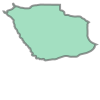

In [28]:
tracts.iloc[11,1]

## Individual trajectory data

In [29]:
print(data.shape)
data.head()

(4687481, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,47.499024,-122.224862
1,1,2020-03-01 12:41:14.411882,47.500657,-122.220274
2,1,2020-03-01 14:11:23.605911,47.531125,-122.357910
3,1,2020-03-01 14:33:43.544832,47.500657,-122.220274
4,1,2020-03-01 14:53:52.198258,47.531125,-122.357910


### This takes 5-8 seconds

In [30]:
# Convert latitude/longitude into Point geometry
geometry = [Point(xy) for xy in zip(data["lng"], data["lat"])] #Convert coordinate to points

# Create a GeoDataFrame with the same CRS as the Census Tract shapefile
points_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

points_gdf.head()  # Check that geometry was created correctly

,uid,datetime,lat,lng,geometry
0,1,2020-03-01 00:00:00.000000,47.499024,-122.224862,POINT (-122.22486 47.49902)
1,1,2020-03-01 12:41:14.411882,47.500657,-122.220274,POINT (-122.22027 47.50066)
2,1,2020-03-01 14:11:23.605911,47.531125,-122.357910,POINT (-122.35791 47.53113)
3,1,2020-03-01 14:33:43.544832,47.500657,-122.220274,POINT (-122.22027 47.50066)
4,1,2020-03-01 14:53:52.198258,47.531125,-122.357910,POINT (-122.35791 47.53113)


In [31]:
# Convert Census Tract shapefile to the same CRS as the points
# This is to make sure both data use EPSG:4326
tracts = tracts.to_crs(points_gdf.crs)
tracts.head()

,GEOID,geometry,County
0,530039603004,"POLYGON ((-117.05053 46.41287, -117.05044 46.4...",53003
1,530039604001,"POLYGON ((-117.07434 46.41774, -117.07429 46.4...",53003
2,530039604002,"POLYGON ((-117.07960 46.41444, -117.07931 46.4...",53003
3,530039605002,"POLYGON ((-117.05079 46.40887, -117.05078 46.4...",53003
4,530039605003,"POLYGON ((-117.05864 46.40365, -117.05864 46.4...",53003


In [32]:
#Proceed when we see the same CRS value
print("Tracts CRS:", tracts.crs)
print("Points CRS:", points_gdf.crs)

Tracts CRS: EPSG:4326
Points CRS: EPSG:4326


## This takes three seconds

In [33]:
print(len(tracts['County'].unique().tolist()))
tracts.head(1)

34


,GEOID,geometry,County
0,530039603004,"POLYGON ((-117.05053 46.41287, -117.05044 46.4...",53003


In [34]:
#Perform spacial join
joined_gdf = gpd.sjoin(points_gdf, tracts, how="left", predicate="within")
print(joined_gdf.shape)
joined_gdf.head(3)

(4687481, 8)


,uid,datetime,lat,lng,geometry,index_right,GEOID,County
0,1,2020-03-01 00:00:00.000000,47.499024,-122.224862,POINT (-122.22486 47.49902),720.0,530330260043,53033
1,1,2020-03-01 12:41:14.411882,47.500657,-122.220274,POINT (-122.22027 47.50066),3426.0,530330253023,53033
2,1,2020-03-01 14:11:23.605911,47.531125,-122.357910,POINT (-122.35791 47.53113),3391.0,530330114013,53033


In [35]:
joined_gdf['datetime'] = pd.to_datetime(joined_gdf['datetime'])
joined_gdf['day'] = joined_gdf['datetime'].dt.day
joined_gdf.tail(3)

,uid,datetime,lat,lng,geometry,index_right,GEOID,County,day
4687478,10000,2020-03-30 22:25:42.376638,47.861257,-122.288708,POINT (-122.28871 47.86126),2040.0,530610501024,53061,30
4687479,10000,2020-03-30 23:14:53.624814,47.768764,-122.246590,POINT (-122.24659 47.76876),5132.0,530330217011,53033,30
4687480,10000,2020-03-30 23:42:08.826532,47.663052,-122.307438,POINT (-122.30744 47.66305),2580.0,530330053073,53033,30


In [36]:
joined_gdf = joined_gdf[~(joined_gdf['County'].isna())].copy()
print(len(joined_gdf['County'].unique().tolist()))

34


# Groupping

## Here's Where to add noise

In [37]:
#Grouped
grouped_counts = joined_gdf.groupby(['uid', 'day','GEOID']).size().reset_index()
rename = {0 : 'Count'}
grouped_counts = grouped_counts.rename(columns = rename)
grouped_counts.head(10)

,uid,day,GEOID,Count
0,1,1,530330077004,2
1,1,1,530330079023,1
2,1,1,530330108001,1
3,1,1,530330114013,3
4,1,1,530330229011,1
5,1,1,530330249041,1
6,1,1,530330253023,2
7,1,1,530330260043,2
8,1,2,530330063002,2
9,1,2,530330064001,1


In [38]:
grouped_counts.insert(3, "County", grouped_counts['GEOID'].str[:5]) #State + county is a five digit code

#One individual has about 30 unique locations
print(grouped_counts.shape)
grouped_counts.head(5)

(3559938, 5)


,uid,day,GEOID,County,Count
0,1,1,530330077004,53033,2
1,1,1,530330079023,53033,1
2,1,1,530330108001,53033,1
3,1,1,530330114013,53033,3
4,1,1,530330229011,53033,1


In [39]:
unique_id = grouped_counts['uid'].unique().tolist()
print(len(unique_id))

10000


# DP Noise

In [40]:
import opendp.prelude as dp
dp.enable_features("contrib")

#The Loop
privacy_budget = [0.8, 0.5, 0.3, 0.1, 0.05, 0.01, 0.005]
name = ['P8','P5','P3','P1','P05','P01','P005']

# Ensure the 'Count' column is float before applying DP noise
grouped_counts['Count'] = grouped_counts['Count'].astype(int).copy()

for i in range(len(privacy_budget)):
    print(i)
    epsilon = privacy_budget[i] #Privacy budget
    sensitivity = 1
    scale = sensitivity / epsilon
    
    # Create the Laplace mechanism
    laplace_mechanism = dp.m.make_laplace(
        dp.atom_domain(T=int), dp.absolute_distance(T=int), scale)
    
    #Define the Laplace function
    def apply_dp_noise(count):
        return laplace_mechanism(count)
    
    #Name for the new column
    text = name[i]
    
    grouped_counts[f'Count_{text}'] = grouped_counts['Count'].apply(lambda x: max(laplace_mechanism(x), 0))
    

0
1
2
3
4
5
6


In [41]:
grouped_counts.head(10)

,uid,day,GEOID,County,Count,Count_P8,Count_P5,Count_P3,Count_P1,Count_P05,Count_P01,Count_P005
0,1,1,530330077004,53033,2,0,0,1,0,13,0,270
1,1,1,530330079023,53033,1,0,2,2,6,0,0,50
2,1,1,530330108001,53033,1,1,1,5,6,0,69,520
3,1,1,530330114013,53033,3,2,2,7,14,0,0,0
4,1,1,530330229011,53033,1,3,1,0,0,15,21,27
5,1,1,530330249041,53033,1,0,6,3,0,9,46,437
6,1,1,530330253023,53033,2,2,2,2,0,5,0,516
7,1,1,530330260043,53033,2,4,2,0,10,0,0,151
8,1,2,530330063002,53033,2,0,4,7,8,75,103,0
9,1,2,530330064001,53033,1,5,5,1,0,28,0,35


#

# Home Location

In [42]:
home = pd.read_csv("Home_location_4Week_10000_WA_realpop.csv")
home = home.drop(columns = 'Unnamed: 0')
print(home.shape)
home.head()

(10000, 3)


,uid,lat,lng
0,1,47.619176,-122.299747
1,2,47.619195,-122.294069
2,3,47.200451,-122.306044
3,4,47.565443,-122.643190
4,5,45.703995,-122.698107


In [43]:
# Convert latitude/longitude into Point geometry
geometry = [Point(xy) for xy in zip(home["lng"], home["lat"])] #Convert coordinate to points

# Create a GeoDataFrame with the same CRS as the Census Tract shapefile
home_points_gdf = gpd.GeoDataFrame(home, geometry=geometry, crs="EPSG:4326")

home_points_gdf.head()  # Check that geometry was created correctly

,uid,lat,lng,geometry
0,1,47.619176,-122.299747,POINT (-122.29975 47.61918)
1,2,47.619195,-122.294069,POINT (-122.29407 47.61919)
2,3,47.200451,-122.306044,POINT (-122.30604 47.20045)
3,4,47.565443,-122.643190,POINT (-122.64319 47.56544)
4,5,45.703995,-122.698107,POINT (-122.69811 45.70400)


In [44]:
print("Tracts CRS:", tracts.crs)
print("Points CRS:", home_points_gdf.crs)

Tracts CRS: EPSG:4326
Points CRS: EPSG:4326


In [45]:
print(len(tracts['County'].unique().tolist()))
tracts.head(3)

34


,GEOID,geometry,County
0,530039603004,"POLYGON ((-117.05053 46.41287, -117.05044 46.4...",53003
1,530039604001,"POLYGON ((-117.07434 46.41774, -117.07429 46.4...",53003
2,530039604002,"POLYGON ((-117.07960 46.41444, -117.07931 46.4...",53003


In [46]:
home_joined_gdf = gpd.sjoin(home_points_gdf, tracts, how="left", predicate="within")
print(home_joined_gdf.shape)
home_joined_gdf.head(3)

(10000, 7)


,uid,lat,lng,geometry,index_right,GEOID,County
0,1,47.619176,-122.299747,POINT (-122.29975 47.61918),4757.0,530330077004,53033
1,2,47.619195,-122.294069,POINT (-122.29407 47.61919),4756.0,530330077001,53033
2,3,47.200451,-122.306044,POINT (-122.30604 47.20045),2942.0,530530734072,53053


In [47]:
#home geoid at the county level
home_joined_gdf['home_geoid'] = home_joined_gdf['GEOID'].str[:5] 
home_joined_gdf.head(3)

,uid,lat,lng,geometry,index_right,GEOID,County,home_geoid
0,1,47.619176,-122.299747,POINT (-122.29975 47.61918),4757.0,530330077004,53033,53033
1,2,47.619195,-122.294069,POINT (-122.29407 47.61919),4756.0,530330077001,53033,53033
2,3,47.200451,-122.306044,POINT (-122.30604 47.20045),2942.0,530530734072,53053,53053


In [48]:
print(len(home_joined_gdf['home_geoid'].unique().tolist()))

35


### This is where home list is computed!!! Important!!!

In [49]:
#Home list------------------------------------------------!!------------!!-----------
home_list = home_joined_gdf['home_geoid'].tolist()
len(home_list)

10000

In [50]:
home = home_joined_gdf[home_joined_gdf['uid'] == 1]['GEOID'][0]
home

'530330077004'

In [51]:
us_shape_file = pd.read_csv("../../Data/us_shapefile_county.csv")

#rename column
rename = {"FIPS code" : "GEOID"}
us_shape_file = us_shape_file.rename(columns = rename)
us_shape_file["GEOID"] = us_shape_file["GEOID"].apply(lambda x: f"{int(x):05d}")
us_shape_file = us_shape_file[['GEOID','pop2020']].copy()
us_shape_file.tail(3)

,GEOID,pop2020
3106,06037,9989165.0
3107,46113,14309.0
3108,51515,6599.0


In [52]:
home_groped= home_joined_gdf.groupby('home_geoid').size().reset_index(name='Count')
rename = {'home_geoid' :'GEOID'}
home_groped = home_groped.rename(columns = rename)
home_groped.head(3)

,GEOID,Count
0,53001,20
1,53003,39
2,53005,267


In [53]:
home_merged = pd.merge(us_shape_file, home_groped, on = 'GEOID', how = 'inner')
home_merged.head(3)

,GEOID,pop2020,Count
0,53059,12034.0,6
1,53051,13482.0,11
2,53055,17818.0,15


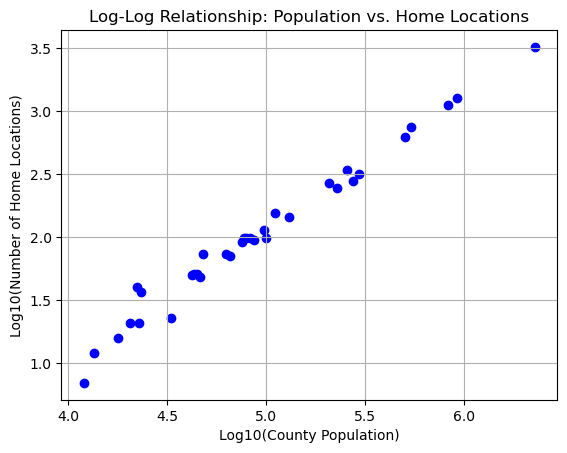

In [54]:
home_merged['log_pop2021'] = np.log10(home_merged['pop2020'] + 1)
home_merged['log_Count'] = np.log10(home_merged['Count'] + 1)

import matplotlib.pyplot as plt

plt.scatter(home_merged['log_pop2021'], home_merged['log_Count'], color='blue')
#plt.scatter(home_merged['pop2021'], home_merged['Count'], color='blue')
plt.xlabel('Log10(County Population)')
plt.ylabel('Log10(Number of Home Locations)')
plt.title('Log-Log Relationship: Population vs. Home Locations')
plt.grid(True)
plt.show()

### Test if it is a linear relationship

In [55]:
from sklearn.linear_model import LinearRegression

# Reshape X to 2D
X = home_merged[['pop2020']]  # double brackets = 2D DataFrame
y = home_merged['Count']

model = LinearRegression()
model.fit(X, y)

r_squared = model.score(X, y)
print("R² score:", r_squared)

slope = model.coef_[0]
intercept = model.intercept_

print(f"Estimated slope (β₁): {slope}")
print(f"Estimated intercept (β₀): {intercept}")

R² score: 0.9974522729679544
Estimated slope (β₁): 0.001412750243274121
Estimated intercept (β₀): -25.442753206727104


#

# The Loop

In [60]:
print(grouped_counts.shape)
grouped_counts.head(5)

(3559938, 12)


,uid,day,GEOID,County,Count,Count_P8,Count_P5,Count_P3,Count_P1,Count_P05,Count_P01,Count_P005
0,1,1,530330077004,53033,2,0,0,1,0,13,0,270
1,1,1,530330079023,53033,1,0,2,2,6,0,0,50
2,1,1,530330108001,53033,1,1,1,5,6,0,69,520
3,1,1,530330114013,53033,3,2,2,7,14,0,0,0
4,1,1,530330229011,53033,1,3,1,0,0,15,21,27


### Assign home locaton to each individual

In [61]:
# Enpty Data Frame
ori_des_df = pd.DataFrame()
person_id = grouped_counts["uid"].unique().tolist()

#The Loop
for i in range(len(person_id)):
    
    if i % 4000 == 0:
        print(i)
    
    #Reset_index: This makes sure that everytime we do the subset, index start with 1
    person = grouped_counts[grouped_counts['uid'] == person_id[i]].reset_index().copy()
    person = person.drop(columns = ['index']) #since it create a separate column of index, we drop it!
    
    #Use existing data to find home location
    Origin = home_list[i]
    
    #Insert Origin, shift county to the right as 'Destination'
    person.insert(3, "Origin", Origin)
    
    #rename column
    rename = {'County': 'Destination'}
    person = person.rename(columns = rename)
    
    #Concat the result
    #Note that each row are count for one census block, convert them into origin and destinaion
    ori_des_df = pd.concat([ori_des_df, person], axis = 0)

0
4000
8000


In [214]:
print(ori_des_df.shape)
ori_des_df.head(3)
#ori_des_df.to_excel("ori_des_df.xlsx")

(3559997, 13)


,uid,day,GEOID,Origin,Destination,Count,Count_P8,Count_P5,Count_P3,Count_P1,Count_P05,Count_P01,Count_P005
0,1,1,530330077004,53033,53033,2,3,0,4,0,2,320,223
1,1,1,530330079023,53033,53033,1,0,6,4,0,0,277,0
2,1,1,530330108001,53033,53033,1,0,0,1,0,38,15,635


In [62]:
#Make sure origin and destination are all within counties of interest
ori_des_df = ori_des_df[ori_des_df['Origin'].isin(E_wa_index)]
ori_des_df = ori_des_df[ori_des_df['Destination'].isin(E_wa_index)]

In [63]:
ori_des_df.shape

(3559569, 13)

#

# Computing Weight Matrix

### Average Matrix Epsilon

In [64]:
def avg_mt_epsilon(Count):
    
    '''
    Calculating average mobility matrix for each day (1–30).
    This returns a dictionay of Daily Matrix
    '''
    
    Matrix_dict = {}

    for i in range(30):
        n = i + 1
        df = ori_des_df[ori_des_df['day'] == n]
        
        county_group = df.groupby(['Origin', 'Destination'])[Count].sum().reset_index()

        count_Matrix = county_group.pivot_table(index='Origin', 
                                                columns='Destination', 
                                                values= Count, 
                                                fill_value=0)
        
        #This is a new line of code added by ChatGTP: sort index in accending order
        count_Matrix = count_Matrix.sort_index().sort_index(axis=1)

        origin_list = count_Matrix.index.tolist()
        destination_list = count_Matrix.columns.tolist()
        #This is just to ensure if the row index and column index are in the same orde
        #As well as to ensure they also equals to the initial SEIR condition county order
        #If nothing goes wrong the loop will not print anything

        if origin_list != destination_list:
            print(f'Day {n}: origin list ≠ destination list')

        if origin_list != E_wa_index:
            print(f'Day {n}: origin list ≠ SEIR initial condition list')

        Matrix = count_Matrix.reset_index(drop=True)
        Matrix_dict[n] = Matrix

    return Matrix_dict

### Daily Average Matrix

In [65]:
def daily_avg_wtmt(Matrix_dict):
    
    '''
    This function compute the daily average mobility matrix
    '''
    total_visit = Matrix_dict[1].copy()
    mt_length = len(total_visit.columns)
    
    for i in range(1, 30):
        n = i + 1 #n therefore starts from 2
        #print(n)
        
        if n % 10 == 0:
            print(n)
            
        total_visit += Matrix_dict[n]
        
    daily_avg_visit = total_visit/30
    
    divisor = [daily_avg_visit.iloc[i].sum() for i in range(mt_length)]
    average_wt_mt = daily_avg_visit.div(divisor, axis=0)
    
    return average_wt_mt

# Saving the Weight Matrix

In [102]:
Matrix_dict = avg_mt_epsilon('Count')
Matrix_dict[1].head(3)

Destination,53001,53003,53005,53007,53009,53011,53015,53017,53021,53025,...,53057,53059,53061,53063,53065,53067,53071,53073,53075,53077
0,196,0,8,2,0,7,0,5,11,6,...,0,0,5,31,3,2,2,26,0,7
1,0,672,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,10,0
2,11,0,3687,1,3,21,4,0,522,23,...,0,0,15,43,10,10,29,7,3,75


In [103]:
daily_avg = daily_avg_wtmt(Matrix_dict)
daily_avg.head(3)

10
20
30


Destination,53001,53003,53005,53007,53009,53011,53015,53017,53021,53025,...,53057,53059,53061,53063,53065,53067,53071,53073,53075,53077
0,0.394639,0.000000,0.055023,0.030399,0.000545,0.024406,0.007736,0.015036,0.042820,0.023317,...,0.000000,0.000000,0.029200,0.085422,0.003922,0.004249,0.008499,0.046306,0.004140,0.026694
1,0.000000,0.917968,0.003904,0.000220,0.000000,0.001100,0.000275,0.000110,0.003299,0.000385,...,0.002694,0.000000,0.003739,0.013800,0.002804,0.001869,0.001649,0.000110,0.016439,0.000330
2,0.001535,0.000008,0.738961,0.000639,0.000240,0.005779,0.000496,0.000184,0.161487,0.004964,...,0.000192,0.000016,0.005532,0.010416,0.000919,0.002710,0.006739,0.002382,0.000576,0.023861


In [104]:
# Calculations
import statistics

average_wt_mt_np = daily_avg.to_numpy()
Pii_skmob = [average_wt_mt_np[i][i] for i in range(34)]


data = Pii_skmob 
mean_value = sum(data) / len(data)  # Mean
median_value = statistics.median(data)  # Median
min_value = min(data)  # Min
max_value = max(data)  # Max

# Output
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")

Mean: 0.5674103700330021
Median: 0.5791140792056435
Min: 0.15297047314123088
Max: 0.9704900914807166


In [99]:
daily_avg.to_csv("WA_ori_indi.csv")

# Compares it to the Original

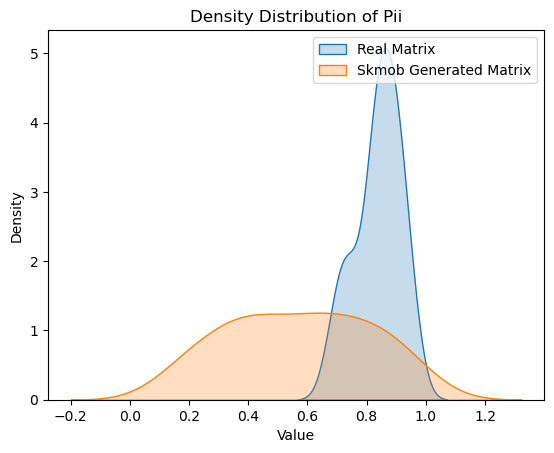

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create KDE plot
sns.kdeplot(Pii_ori, label="Real Matrix", fill=True)
sns.kdeplot(Pii_skmob, label="Skmob Generated Matrix", fill=True)

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Density Distribution of Pii")
plt.legend()

#Lables and legend
#plt.savefig("Pii_Comparison.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()
